In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
# for class imbalance
from imblearn.over_sampling import SMOTE

from keras import models
from keras import layers
from keras import optimizers

-----

### --In the process & Further steps--

-Model tuninig<br>
-remove 5/4 timing, try predicting the two most common classes in time signature 4/4 and 3/4<br>
-check on time signature confidence, set a threshold and remove rows which don't pass the threshold feed this into models<br>
-More feature engineering, the mean for each MFCC vector may not be the correct choice
-Use the full MFCC vector and feed into Sequential neural net

----

### Baseline Model

In [3]:
df = pd.read_csv('final_df.csv', index_col=0)
df.head(3)

,track_id,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,time_signature
0,10.0,-17.238174,94.442024,-48.614548,32.370766,-4.550584,2.220590,-2.271865,2.682117,-5.288854,...,2.239940,-6.416430,2.677109,-5.104513,-0.911098,-3.207996,3.043154,-1.036512,3.882601,4.0
1,141.0,-208.569260,116.633934,-1.723712,26.018599,9.688706,-4.179668,7.235491,-5.119752,-0.052033,...,-3.396803,-4.810870,3.130367,-2.126665,5.053833,-0.170090,3.087436,-8.665928,-1.098168,3.0
2,213.0,-264.020782,160.387070,0.499303,15.058126,12.012090,-8.957160,-10.785332,0.959413,-8.229311,...,-5.370893,-4.490613,-11.134265,-18.518158,-2.583431,-4.884125,1.371706,4.428988,-3.584380,4.0


In [4]:
df['time_signature'].value_counts()

4.0    1034
3.0     128
5.0      42
1.0      17
0.0       1
Name: time_signature, dtype: int64

In [5]:
# dropping all rows where the time signature is 1 or 0
df = df[(df['time_signature'] != 0) & (df['time_signature'] != 1)]

In [6]:
df['time_signature'].value_counts()

4.0    1034
3.0     128
5.0      42
Name: time_signature, dtype: int64

In [7]:
X = df.drop(columns=['track_id', 'time_signature'])
y = df['time_signature']

In [8]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.8588039867109635

In [9]:
colors =  ['#73997b','#617f8c','#675970']

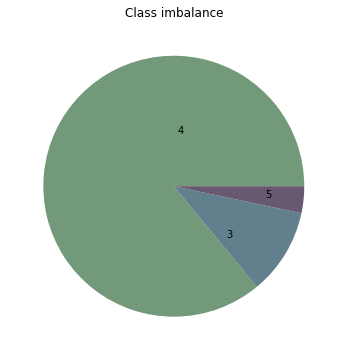

In [12]:
plt.figure(figsize=(8,6));
plt.pie(y_train.value_counts(), colors=colors);
plt.text(.03,.4,'4')
plt.text(.7,-.09,'5')
plt.text(.4,-.4,'3')
plt.title('Class imbalance');
plt.savefig('class_imbalance.png')

In [13]:
y_train.value_counts(normalize=True)

4.0    0.859813
3.0    0.106957
5.0    0.033229
Name: time_signature, dtype: float64

#### Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=12)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(963, 20)
(241, 20)
(963,)
(241,)


### Upsampling the smaller classes

In [15]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [16]:
print(X_res.shape)
print(y_res.shape)

(2484, 20)
(2484,)


In [17]:
pd.DataFrame(y_res)[0].value_counts(normalize=True)

3.0    0.333333
5.0    0.333333
4.0    0.333333
Name: 0, dtype: float64

### Knn Model

In [88]:
# Need to scale the data

In [85]:
knn = KNeighborsClassifier()
knn.fit(X_res, y_res)
knn_preds = knn.predict(X_test)
print(accuracy_score(y_test, knn_preds))
print(f1_score(y_test, knn_preds, average=None))
confusion_matrix(y_test, knn_preds)

0.5020746887966805
[0.1978022  0.65853659 0.12698413]


array([[  9,  11,   5],
       [ 54, 108,  44],
       [  3,   3,   4]])

### Random Forest

In [65]:
rf_clf = RandomForestClassifier(n_estimators=50)
rf_clf.fit(X_res, y_res)
rf_preds = rf_clf.predict(X_test)

In [86]:
print(accuracy_score(y_test, rf_preds))
print(f1_score(y_test, rf_preds, average=None))
print(confusion_matrix(y_test, rf_preds))

0.7717842323651453
[0.12       0.87290168 0.13333333]
[[  3  22   0]
 [ 20 182   4]
 [  2   7   1]]


In [68]:
########  NOTES

# this seems to be working well. got to play with hyper parameters

### X gboost

In [91]:
xgb_clf = XGBClassifier(objective='multi:softmax')
xgb_clf.fit(pd.DataFrame(X_res, columns=X_train.columns), y_res)
xgb_preds = xgb_clf.predict(X_test)
accuracy_score(y_test, xgb_preds)

0.7759336099585062

In [92]:
f1_score(y_test, xgb_preds, average=None)

array([0.17021277, 0.87290168, 0.11111111])

### GridSearch

In [93]:
param_xgb = {'n_estimators': [100,300,500],
              'learning_rate': [0.1,0.07,0.05,0.03,0.01],
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }

In [95]:
gsearch_xgb = GridSearchCV(
                estimator = xgb_clf,
                param_grid = param_xgb, 
                scoring='accuracy',
                n_jobs=-1,
                verbose=1, 
                cv=5)

In [96]:
gsearch_xgb.fit(pd.DataFrame(X_res, columns=X_train.columns), y_res)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed: 32.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_esti...
                                     scale_pos_weight=None, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_byt

In [97]:
gsxbg_preds = gsearch_xgb.best_estimator_.predict(X_test)

In [99]:
print(accuracy_score(y_test, gsxbg_preds))
print(f1_score(y_test, gsxbg_preds, average=None))
confusion_matrix(y_test, gsxbg_preds)

0.7842323651452282
[0.17021277 0.88192771 0.2       ]


array([[  4,  20,   1],
       [ 16, 183,   7],
       [  2,   6,   2]])

### Neural Nets

In [101]:
nn = models.Sequential()

## Setting threshold for time sig confidence & removing 5/4 timing

In [23]:
# retrieving track id and time signature
conf_df = pd.read_csv('clean_track_info.csv',index_col=0)[['tracks_id', 'time_sig_confidence']]

In [47]:
# checking dist
conf_df['time_sig_confidence'].quantile(.25)

0.804

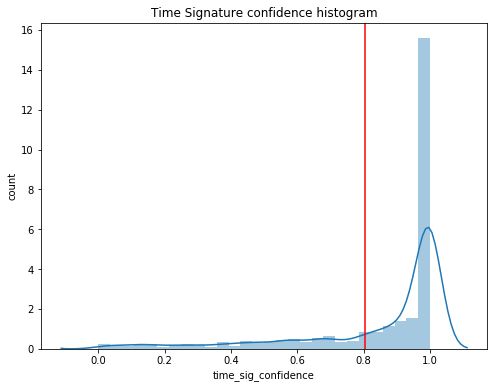

In [53]:
# visualizing dist
plt.figure(figsize=(8,6));
plt.title('Time Signature confidence histogram');
plt.ylabel('count');
sns.distplot(conf_df['time_sig_confidence']);
plt.axvline(conf_df['time_sig_confidence'].quantile(.25),color='r');

In [56]:
# joining tables for filtering later
merged_df = pd.merge(df,conf_df,left_on='track_id', right_on='tracks_id').drop(columns=['tracks_id'])

In [61]:
# filtered data frame for sig confidence above .8
filtered_df = merged_df[(merged_df['time_sig_confidence'] >= .8) & (merged_df['time_signature'] != 5)]

In [63]:
# checking distribution on filtered dataframe
filtered_df['time_signature'].value_counts(normalize=True)

4.0    0.934444
3.0    0.065556
Name: time_signature, dtype: float64